## Pre-MCMC calculations

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import astropy
import scipy.integrate as integrate
import pandas
from astropy.cosmology import FlatLambdaCDM
from IPython.display import display, Math

In [2]:
# Importing constants 

Planck = astropy.cosmology.realizations.Planck18

T_CMB = Planck.Tcmb0  # Temperature of the CMB
H_0 = Planck.H0  # Current Hubble constant
Omega_m = Planck.Om0  # Matter density parameter
Omega_lambda = Planck.Ode0  # Dark energy density parameter
c = astropy.constants.c.to('km/s')  # Speed of light in km/s
sigma_T = astropy.constants.sigma_T.to('km2')  # Thomson scattering cross-section in km^2


# Setting parameters

z = 8  # Redshift of the quasar bubbles 
f_H = 0.21  # fraction of neutral hydrogen at z = 8

In [3]:
# Input Data

data = pandas.read_csv('Data/u_0.0pc_noise.csv')

Ang_deg = np.array([data['radius_y'][1]])  # In arcmins
amp = np.array([data['amp_y'][1]]) * 1e-6  # Amplitude in K

In [4]:
# Importing the Flat Lambda CDM model

cosmo = FlatLambdaCDM(H0=H_0.value, Om0=Omega_m, Tcmb0= T_CMB.value)


# Obtaining the angular diameter distance at z

D_A = cosmo.angular_diameter_distance(z)  # units: Mpc/radian


# Defining a function that converts from our angular distance to proper distance

def AngToDist(Ang_deg= Ang_deg):
    
    Ang_rad = Ang_deg * np.pi / (180 * 60)  # Convert arcmins to radians
    Distance = D_A * Ang_rad  # Convert angular distance to actual distance

    return Distance


In [5]:
# Calculating the actual radii of the bubbles and y

Radius = AngToDist(Ang_deg)  # in Mpc

y = amp / T_CMB.value  

In [6]:
# Calculating n_e and n_H

n_e = y * 3 * np.sqrt(1+z) / (sigma_T * 0.001 * 2 * Radius.to('km'))

n_H = n_e / (1 - f_H)  # Assuming all electrons are from ionized hydrogen
n_H

<Quantity [6.90633258e+11] 1 / km3>

----

## MCMC Sampling

In [7]:
# Defining the model using the Stromgren sphere approximation

def model(theta, n_H): 
    N_dot, t_Q = theta
    return (((3*N_dot*t_Q)/(4*np.pi*n_H))**(1/3)) * (1+z)**(-1)

In [8]:
# Setting up initial, lower and upper bounds for the parameters

N_dot_ini = 10**58  # in s^-1
N_dot_min =  10**56  # in s^-1
N_dot_max = 10**64  # in s^-1

t_Q_ini = 10**7  # in years
t_Q_ini = t_Q_ini * 3.156e7  # in s
t_Q_min = 10**5  # in years
t_Q_min = t_Q_min * 3.156e7  # in s 
t_Q_max = 10**10  # in years
t_Q_max = t_Q_max * 3.156e7  # in s

In [9]:
# Calculating error in the diameter

Ang_err = np.array([0.5] * len(Ang_deg))  # Error in determining the angular diameter in arcmins
Radius_err = Ang_err * np.pi / (180 * 60) * D_A  # Convert angular error to actual diameter error

In [10]:
# Defining the log-likelihood function

def lnlike(theta, x, y, y_err):
    return -0.5 * np.sum(((y - model(theta, x)) / y_err) ** 2)

# Defining the log-prior function

def lnprior(theta):
    N_dot, t_Q = theta
    if N_dot < N_dot_min or t_Q < t_Q_min or N_dot > N_dot_max  or t_Q > t_Q_max:
        return -np.inf
    return 0.0

# Defining the log-posterior function

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


In [11]:
# Setting initial values for the parameters
initial = [N_dot_ini, t_Q_ini]  

# Setting up the MCMC sampler
ndim = len(initial)
nwalkers = 5 * ndim    # Preferentially 3-5 times the number of dimensions (minimum 2 times the number of dimensions)
n_burn = 200
n_steps = 10000

# Initializing the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(n_H, Radius, Radius_err))

# Adding little variation to the initial positions
p0 = []
for i in range(nwalkers):
    pos = [N_dot_ini, t_Q_ini]  # Start with the initial values
    pos[0] = pos[0] + 1e-4 * pos[0] * np.random.random(1)[0]  # Adding a small random variation to N_dot
    pos[1] = pos[1] + 1e-4 * pos[1] * np.random.random(1)[0]  # Adding a small random variation to t_Q
    p0.append(pos)   


In [12]:
# Running the MCMC sampler

# Burn-in phase
print("Running burn-in phase...")
sampler.reset()
state = sampler.run_mcmc(p0, n_burn, progress=True)
sampler.reset()

# Main sampling phase
print("Running main sampling phase...")
pos, prob, state = sampler.run_mcmc(state, n_steps, progress=True)

# Extracting the samples
samples = sampler.get_chain(flat=True)      # Flatten the chain to get all samples in a single array


Running burn-in phase...


100%|██████████| 200/200 [00:00<00:00, 205.73it/s]


Running main sampling phase...


100%|██████████| 10000/10000 [00:26<00:00, 377.61it/s]


In [40]:
print("N_dot:", med_params[0], "; t_Q (in years):", med_params[1]/3.156e7)

mcmc = np.percentile(flat_samples[:, 0], [16, 50, 84], axis=0)
q = np.diff(mcmc)
print("N_dot_err: -", q[0], "to +", q[1])

mcmc = np.percentile(flat_samples[:, 1], [16, 50, 84], axis=0)
q = np.diff(mcmc)
print("t_Q_err: -", q[0]/3.156e7, "to +", q[1]/3.156e7, "years")

N_dot: 1.404779150027107e+60 ; t_Q (in years): 1978096486.4136333
N_dot_err: - 8.728834640823674e+59 to + 3.4070148753318054e+60
t_Q_err: - 1398489785.412895 to + 3226162904.1451893 years


In [41]:
# Calculating the radii using the estimated parameters 

med_params = np.median(samples, axis=0)  # The median of the parameters 
print(model(med_params, n_H) * 3.241e-20)  # The estimated radius in Mpc

[11.22850652] km


In [42]:
# The radius_y values
Radius

<Quantity [11.23316626] Mpc>

In [43]:
sampler.acceptance_fraction

array([0.2309, 0.2922, 0.081 , 0.1634, 0.2546, 0.2583, 0.2513, 0.18  ,
       0.2521, 0.2767])

In [46]:
# Sorting the n_H and Radius arrays based on n_H for better visualization

order = np.argsort(n_H)
n_H_ordered = n_H[order]
Radius_ordered = Radius[order]

model_ordered = model(med_params, n_H_ordered).to('Mpc')

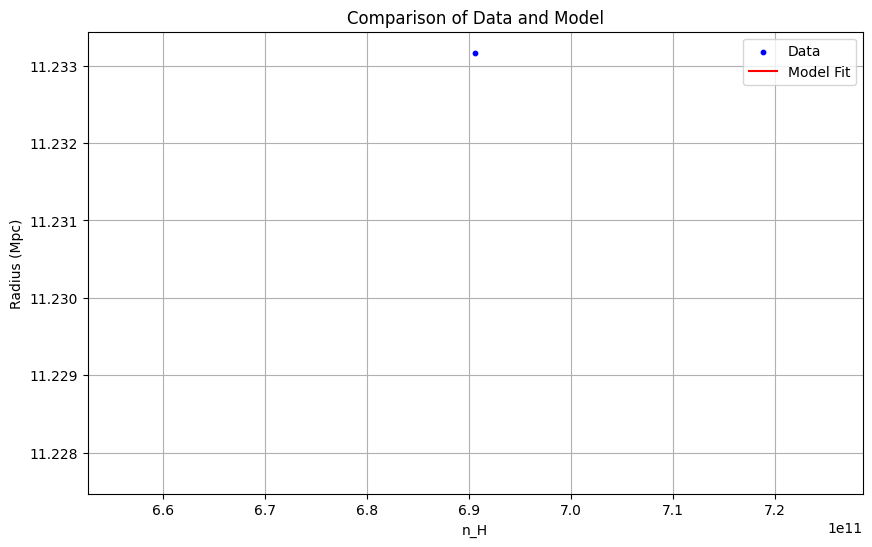

In [50]:
# Plotting the results 

plt.figure(figsize=(10, 6))
plt.scatter(n_H, Radius, label='Data', color='blue', s=10)
plt.plot(n_H_ordered, model(med_params, n_H_ordered).to('Mpc'), label='Model Fit', color='red')
plt.xlabel('n_H')
plt.ylabel('Radius (Mpc)')
plt.title('Comparison of Data and Model')
plt.legend()
plt.grid()
plt.show()


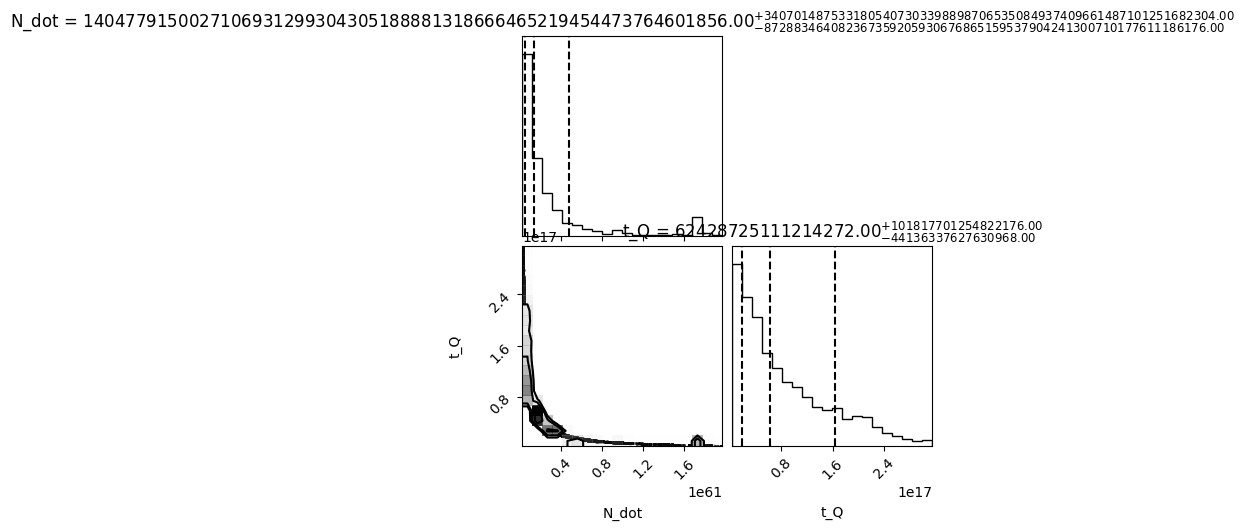

In [48]:
# Plotting a corner plot of the samples along with the quantiles

fig = corner.corner(samples, labels=["N_dot", "t_Q"],  quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_datapoints=True)

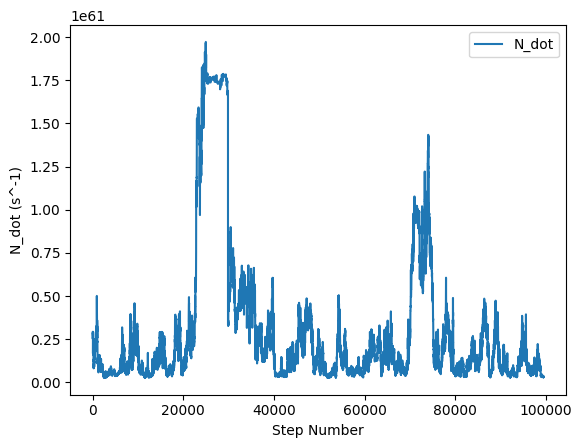

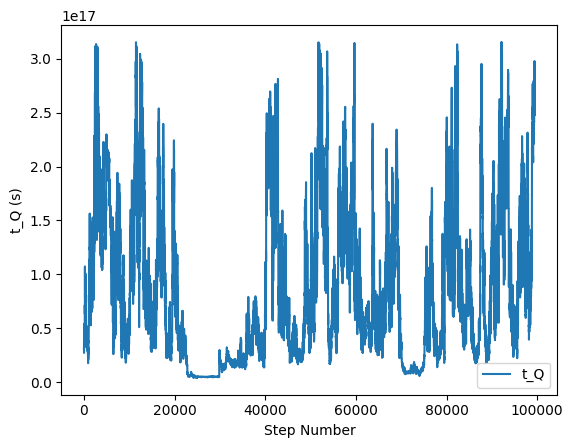

In [49]:
# Plotting the variation with time of the MCMC walkers

chains = sampler.chain[:, 50:, :].reshape((-1, ndim))

plt.plot(np.arange(len(chains[:, 0])), chains[:, 0], label='N_dot')
plt.xlabel('Step Number')
plt.ylabel('N_dot (s^-1)')
plt.legend()
plt.show()

plt.plot(np.arange(len(chains[:, 1])), chains[:, 1], label='t_Q')
plt.xlabel('Step Number')
plt.ylabel('t_Q (s)')
plt.legend()
plt.show()
plt.show()

---

## Comparison with the input data set (Now Redundant)


Here I am performing the same MCMC sampling but with the input data, to compare the output with that of the previous scenario

In [ ]:
# # Importing the input data
# ang_inp = np.array(data.radius_x)  # Input angular radius
                                            
# amp_inp = np.array(data.amp_x) * -1 * 1e-6  # The input amplitude is negative, so we multiply it with -1 (in Kelvin)

In [ ]:
# # Calculating the actual distance and y

# Radius_inp = AngToDist(ang_inp)  # in Mpc

# y_inp = amp_inp / T_CMB.value

In [ ]:
# # Calculating n_e and n_H

# n_e_inp = y * 3 * np.sqrt(1+z) / (sigma_T * 0.001 * 2 * Radius_inp.to('km'))# Initializing the sampler for the input data

# # sampler_inp = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(n_H_inp, Radius_inp, Radius_err))


# # # Running the MCMC Sampler

# # # Burn-in phase
# # print("Running burn-in phase...")
# # sampler_inp.reset()
# # state = sampler_inp.run_mcmc(p0, n_burn, progress=True)
# # sampler_inp.reset()

# # # Main sampling phase
# # print("Running main sampling phase...")
# # pos, prob, state = sampler_inp.run_mcmc(state, n_steps, progress=True)

# # # Extracting the samples
# # samples = sampler_inp.get_chain(flat=True) 


# n_H_inp = n_e_inp / (1 - f_H) 

In [ ]:
# # Initializing the sampler for the input data

# sampler_inp = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(n_H_inp, Radius_inp, Radius_err))


# # Running the MCMC Sampler

# # Burn-in phase
# print("Running burn-in phase...")
# sampler_inp.reset()
# state = sampler_inp.run_mcmc(p0, n_burn, progress=True)
# sampler_inp.reset()

# # Main sampling phase
# print("Running main sampling phase...")
# pos, prob, state = sampler_inp.run_mcmc(state, n_steps, progress=True)

# # Extracting the samples
# samples = sampler_inp.get_chain(flat=True) 


In [ ]:
# # Comparing the N_dot and t_Q values from the input data with the output data
# theta_max_inp = samples[np.argmax(sampler_inp.flatlnprobability)]
# print("INPUT:  N_dot:", theta_max_inp[0], "; t_Q (in years):", theta_max_inp[1]/3.156e7 )
# print("OUTPUT: N_dot:", theta_max[0], "; t_Q (in years):", theta_max[1]/3.156e7 )

In [ ]:
# # Comparing the Radii calculated from the input and output data
# print("INPUT: Radius:", model(theta_max_inp, n_H_inp).to('Mpc'))
# print("OUTPUT: Radius:", model(theta_max, n_H).to('Mpc'))

In [ ]:
# # Actual Radius values
# print("Actual Radius:", Radius_inp)


In [ ]:
# Radius

In [ ]:
# model(theta_max, n_H).to('Mpc')